## Tech Challenge - Fase 2

### Análise e Modelagem Preditiva da Base Histórica de Ações do Ibovespa

Iremos trabalhar com a base histórica de dados do Ibovespa (desde 2019) para realizar uma análise da série temporal obtida, a fim de verificarmos potênciais comportamentos e criar um modelo preditivo para dados futuros de aberturas e fechamentos do ativo. 

Um ponto importante é a definição do Índice do Ibovespa que é o mais importante indicador do desempenho médio das cotações das ações negociadas na B3 - Brasil. Dessa forma, espera-se que como ele é um índice ponderado das ações negociadas, ele é menos volátil que ações de empresas individuais ou ETF's (conjunto de algumas empresas).

Primeiramente, carrega-se a base de dados do Ibovespa e realiza-se uma análise exploratória profunda.

In [1]:
#Libs:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from matplotlib.lines import Line2D
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
#Formato para Parser de date type:
dateparse = lambda x: datetime.strptime(x, '%d.%m.%Y')

In [3]:
#Carregando Dados:
df = pd.read_csv('Dados Históricos - Ibovespa.csv', parse_dates=['Data'], date_parser = dateparse)

In [4]:
#Tipos:
print("Tipos dos Dados da Base Lida...")
df.dtypes

Tipos dos Dados da Base Lida...


Data        datetime64[ns]
Último             float64
Abertura           float64
Máxima             float64
Mínima             float64
Vol.                object
Var%                object
dtype: object

Utilizando um *date parser* direto na função do pandas para leitura dos dados nos poupa um certo trabalho na hora da conversão do campo para um formato de *datetime*. Agora vamos analisar essa série temporal como um todo.

In [5]:
print("Valores Nulos na Df:")
df.isnull().sum()

Valores Nulos na Df:


Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        0
Var%        0
dtype: int64

In [6]:
df.describe()

,Último,Abertura,Máxima,Mínima
count,1136.000000,1136.000000,1136.000000,1136.000000
mean,106.874827,106.845112,107.883191,105.812617
std,10.940137,10.944772,10.753477,11.088323
min,63.570000,63.604000,67.604000,61.691000
25%,100.455750,100.409250,101.519750,99.412000
50%,107.472500,107.441000,108.405500,106.416500
75%,114.681250,114.638750,115.520250,113.389000
max,130.776000,130.776000,131.190000,129.526000


Os valores do índice ficam próximos em quase todas as variáveis, e com uma amplitude relativamente baixa e desvios bem similares. No Próximo passo iremos plotar todas as séries para avaliarmos alguns pontos do comportamento. 

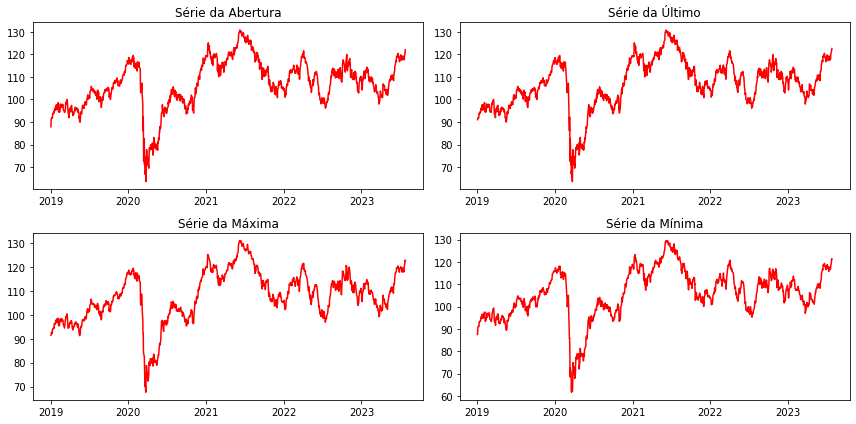

In [7]:
# Create a 4x4 grid of plots
fig, axs = plt.subplots(2, 2, figsize=(12, 6))

# Plot each line plot in the corresponding subplot
axs[0, 0].plot(df["Data"], df["Abertura"], color='red')
axs[0, 0].set_title('Série da Abertura')
axs[0, 1].plot(df["Data"], df["Último"], color='red')
axs[0, 1].set_title('Série da Último')
axs[1, 0].plot(df["Data"], df["Máxima"], color='red')
axs[1, 0].set_title('Série da Máxima')
axs[1, 1].plot(df["Data"], df["Mínima"], color='red')
axs[1, 1].set_title('Série da Mínima')


# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

Como podemos ver, por se tratar de um índice, o IBOVESPA apresenta valores muito próximos de máximos, mínimos e amplitudes ao longo do tempo, dessa forma, seguiremos com os dados de Abertura para podermos trabalhar com um potencial modelo de previsão da abertura do índice.

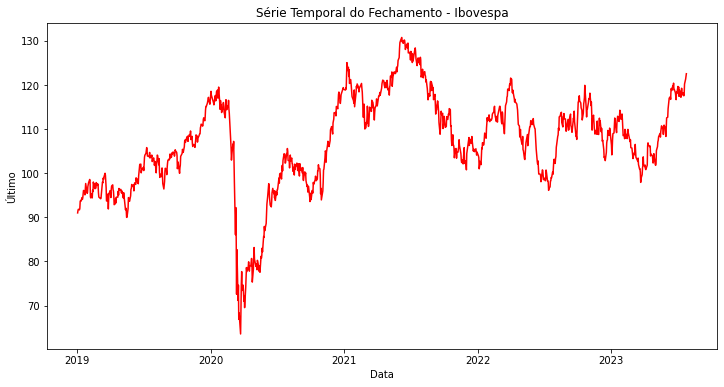

In [8]:
plt.figure(figsize=(12, 6))
sns.lineplot(data = df, x = "Data", y = "Último", color = "red")
title = plt.title("Série Temporal do Fechamento - Ibovespa")
plt.show()

Claramente a série do Fechamento do Índice não pode ser considerada estacionária, simplesmente pelo padrão que ela apresenta ao longo do tempo, e a forma que varia em torno de uma média não constante e distante de 0. 

Apesar de não ser levado em consideração para uma modelagem em um primeiro momento, vale ressaltar que um dos eventos mais influentes nas oscilações da Bolsa de Valores Brasileira é a Taxa de Juros Básica - SELIC. Ela tem um papel significante no comportamento dos ativos da bolsa como um todo, o que também influencia no índice Ibovespa também. 

Resumindo, de acordo com a Corretora Rico e outros players do mercado, quando o Banco Central aumenta a taxa básica de juros para controlar a inflação, há um efeito colateral de desaceleração na economia. Isso ocorre porque o aumento dos juros torna o crédito mais caro para todos, desestimulando o consumo de bens e serviços. Como resultado, setores como o mercado imobiliário perdem demanda, pois os financiamentos se tornam menos atraentes.

Além disso, a política de juros altos incentiva as pessoas a pouparem mais, o que reduz a oferta de investimentos em ativos reais, como imóveis, já que investimentos mais seguros e com rendimentos garantidos se tornam mais atrativos.

Diferentes setores reagem de maneiras distintas às mudanças na taxa de juros. Bancos e seguradoras podem lucrar mais com o aumento dos spreads, mas podem enfrentar aumento da inadimplência. Já empresas de varejo e construção civil são afetadas negativamente, uma vez que o consumo diminui e os gastos menos essenciais são evitados, levando a uma redução nos lucros das empresas.

Em resumo, a desaceleração econômica causada pelo aumento dos juros impacta diversos setores, resultando em uma redução geral dos lucros das empresas e na perda de ímpeto da economia como um todo.

In [9]:
#Lendo dados da SELIC:
df_selic = pd.read_excel("TaxasSELIC.xlsx")
df_ibov_selic = df.merge(df_selic, on = "Data", how = "left")
df_ibov_selic.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Meta SELIC
0,2019-01-02,91.012,87.887,91.479,87.536,"5,79M","3,56%",NaN
1,2019-01-03,91.564,91.011,91.596,89.922,"6,25M","0,61%",NaN
2,2019-01-04,91.841,91.577,92.701,90.824,"5,49M","0,30%",NaN
3,2019-01-07,91.699,91.845,92.552,91.288,"4,71M","-0,15%",NaN
4,2019-01-08,92.032,91.699,92.231,91.064,"4,64M","0,36%",NaN


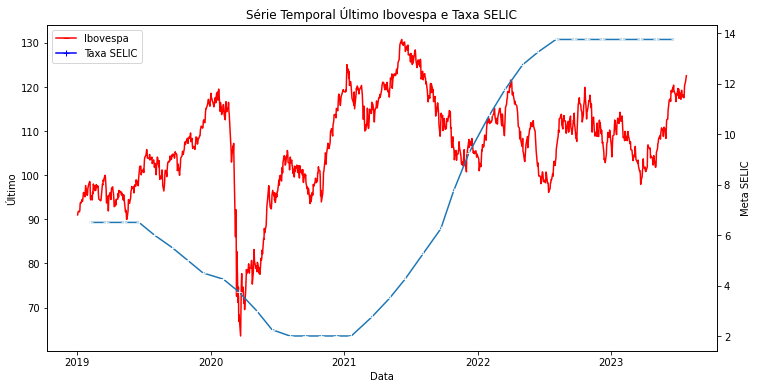

In [10]:
#Plotando as infos Juntas:
plt.figure(figsize=(12, 6))
g = sns.lineplot(data = df_ibov_selic, x = "Data", y = "Último", color="red")
sns.lineplot(data = df_ibov_selic, x = "Data", y = "Meta SELIC", ax=g.axes.twinx(), marker = "+")
g.legend(handles=[Line2D([], [], marker='_', color="red", label='Ibovespa'), 
                  Line2D([], [], marker='+', color="b", label='Taxa SELIC')],
         loc='upper left')
title = plt.title("Série Temporal Último Ibovespa e Taxa SELIC")
plt.show()

Foram selecionados valores da SELIC a partir de 2019, para vermos de forma resumida o efeito que as variações na taxa têm sobreo índice Ibovespa. Pode-se verificar alguns pontos:

- Os cortes e subidas nas taxas de juros não são bruscas, são ciclos graduais;
- Com esses ciclos de reduções e aumentos, o índice tende a ter uma variação positiva ao longo dos ciclos de queda da Taxa SELIC e variações negativas nos ciclos de aumento da taxa;
- Nota-se um dos piores índices no 1º Semestre de 2020, começo da pandemia do COVID.

Um ponto interessante, é que se olharmos a série a partir de 2021/2022, podemos realizar previsões mais acertivas, até uma vez que o ciclo da taxa foi sempre de aumento e a série teve variações positivas e negativas de menor amplitude, tendo acumulos, em geral, menores.

### Etapa de Exploração e Testes de Séries Temporais

Como vimos em etapas anteriores, a série apresenta um comportamento bem volátil, caracteristico de ativos de mercado financeiros, dessa forma, seguiremos para próximas etapas para entendermos caraterísticas mais específicas da série.

Nesta etapa, iremos avaliar a série em alguns aspectos especificos de seu comportamento como tendência, sazonalidade e resíduo. Tal etapa é importante para podermos entender como seguir com a série para uma potencial modelagem. 

In [11]:
#Libs importantes:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

Decompondo a série em seus termos de tendência, sazonalidade e resíduo.

In [12]:
#Decomposição em termos:
res_decomposicao = seasonal_decompose(df.set_index("Data")[["Último"]], period = 30)

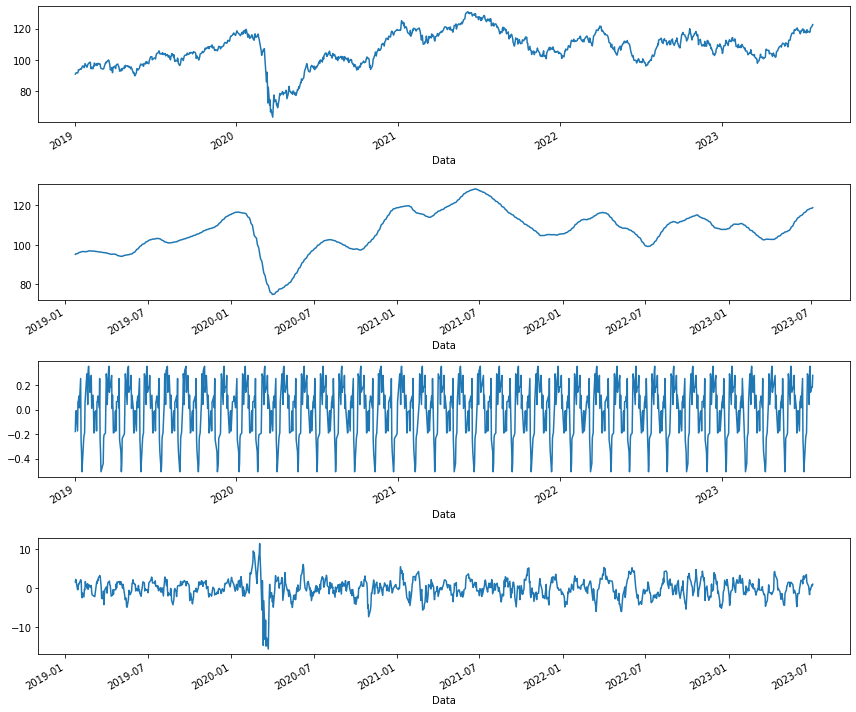

In [13]:
#Plotando os termos:
fig, (p1, p2, p3, p4) = plt.subplots(4, 1, figsize = (12, 10))

res_decomposicao.observed.plot(ax = p1) #Plot Val Observados
res_decomposicao.trend.plot(ax = p2)    #Plot tendencia
res_decomposicao.seasonal.plot(ax = p3) #Plot Sazonalidade
res_decomposicao.resid.plot(ax = p4)    #Plot Residuos
plt.tight_layout()

Usando um período de 30 dias, a decomposição nos trouxe algumas informações interessantes em elação as componentes de tendência e sazonalidade. Veja que o preço de Abertura apresentou uma tendência positiva quando analisamos o período de 12 meses desde 2019, o que faz um certo sentido, até porque contextualizando tivemos a pandemia do COVID-19, o que influenciou em oscilações negativas no mercado como um todo e o mesmo só começou a se recuperar pós a re-abertura da "vida cotidiana" como conheciamos. Além disso, também é possível visualizar uma certa recorrência da série, disposta no termo da sazonalidade, o que também é conveniente, uma vez que o mercado é ciclico, apresentando períodos de crescimentos e quedas, mutio influenciados por fatores gerais da economia nacional e internacional. 

Agora, vamos seguir para outros testes para o comportamento geral da série. Um dos principais pontos a ser abordado é a estacionariedade da série de abertura, ou seja, se ela apresenta um certo comportamento constante ao longo do tempo, oscilando em torno de uma média constante também. De primeira mão, é dificil argumentar que essa série é estacionaria, mas com a ajuda de alguns testes e visualizações podemos verificar tais hipóteses.

O teste que iremos realziar é o de Augmented Dickey Fuller que segue as seguintes suposições:

$$
\begin{cases}
    H_0: \text{série não estacionária} \\
    H_A: \text{série estacionária (rejeição $H_0$)}
\end{cases}
$$

In [14]:
#Função para o teste de Ad Fuller e Print - paa replicação se necessário:
def test_adfuller(serie, title):
    # ADF Test
    print(title)
    result = adfuller(serie)
    print(f'ADF Estatística: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print('Valores Críticos:')
        print(f'   {key}, {value}')

In [15]:
test_adfuller(df.set_index("Data")["Último"].values, "Teste p/ Série de Abertura Observada")

Teste p/ Série de Abertura Observada
ADF Estatística: -2.7554551255907938
p-value: 0.06492378125505029
Valores Críticos:
   1%, -3.4361656672131806
Valores Críticos:
   5%, -2.864107957764881
Valores Críticos:
   10%, -2.568137251515397


De acordo com o teste, se usarmos um nível de significância padrão de 5%, não rejeitamos a hipótese nula de não estacionariedade, e portanto, não podemos assumir um comportamento constante da mesma como já suspeitávamos pelas visualizações. Importante ressaltar que apesar de muito úteis, teste des hipóteses não são mágicos, então mesmo que o p-value desse exatamente em 5% ou um pouco menor, ainda não teriamos uma confiança efetiva da hipótese de estacionaridedade, uma vez que esses testes, de certa forma, corroboram suposições que já temos a priori.

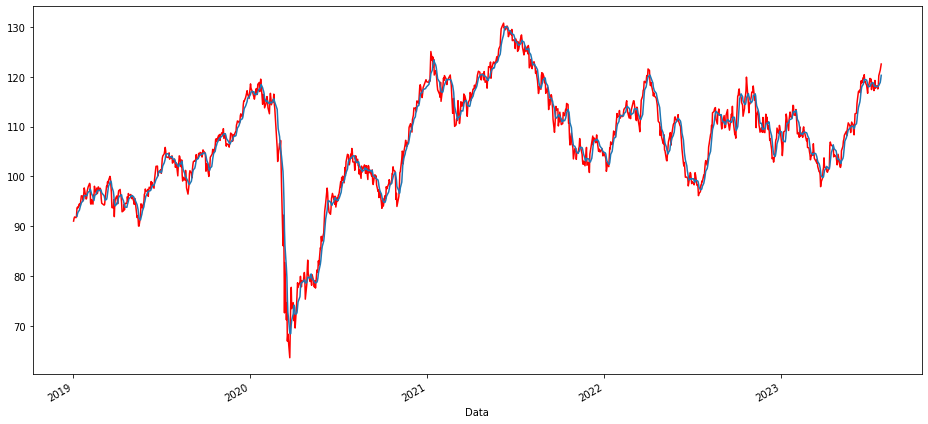

In [16]:
#Média Movel da Série Observada:
serie_observada = df.set_index("Data")[["Último"]]
ma = serie_observada.rolling(6).mean()

f, ax = plt.subplots(figsize = (13, 6))
serie_observada.plot(ax = ax, legend = False, color = "red")
ma.plot(ax = ax, legend = False)
plt.tight_layout()

Com um média móvel de 6 dias temos um comportamento bem similar da série observada. Agora, para tentarmos obter uma série estacionária, vamos mudar a escala da observada utilizando uma transformação log e posteriormente substrairmos a média móvel de 6 dias, a fim de obtermos uma média constante próxima de 0 e um desvio também constante.

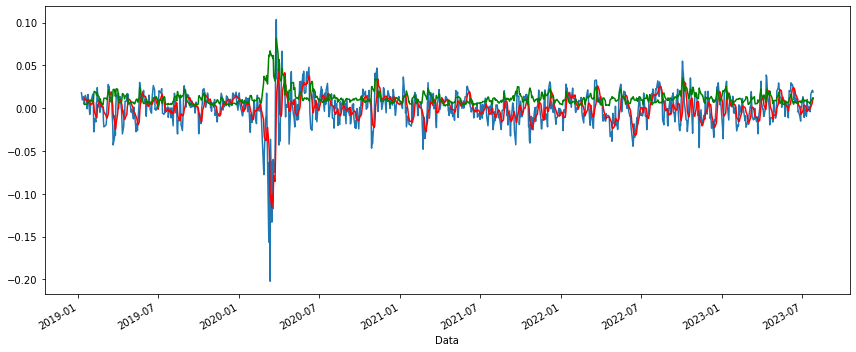

In [17]:
#Serie Transformada:
serie_log = np.log(serie_observada)
ma_log = serie_log.rolling(6).mean()

#Seríe Diferenciada:
serie_s = (serie_log - ma_log).dropna() #substraida
ma_s = serie_s.rolling(6).mean() #media movel
std_s = serie_s.rolling(6).std() #desvio padrão

#Plotando tudo:
f, ax = plt.subplots(figsize = (12, 5))
serie_s.plot(ax = ax, legend = False)
ma_s.plot(ax = ax, legend = False, color = "r")
std_s.plot(ax = ax, legend = False, color = "g")
plt.tight_layout()

In [18]:
test_adfuller(serie_s.values, "Teste p/ Série Transformada e Subtraida")

Teste p/ Série Transformada e Subtraida
ADF Estatística: -8.981867112573271
p-value: 7.273498412568586e-15
Valores Críticos:
   1%, -3.4361864296062166
Valores Críticos:
   5%, -2.864117116658563
Valores Críticos:
   10%, -2.5681421294173714


Agora sim temos uma série que parece ser bastante estacionária. Ao realizar o teste, podemos ver também que rejeitamos a hipótese nula de não estacionariedade da série com uma confiança bem alta, menor que 1% de forma bem confortável.

Algo interessante, é que podemos seguir um passo a mais ainda, realizar uma diferenciação. Diferenciando a série, por se tratar de um modelo aditivo, teriamos algo mais próximo de uma constante a medida que fizessemos mais diferenciações, ou seja, uma série cada vez mais estacionária. 

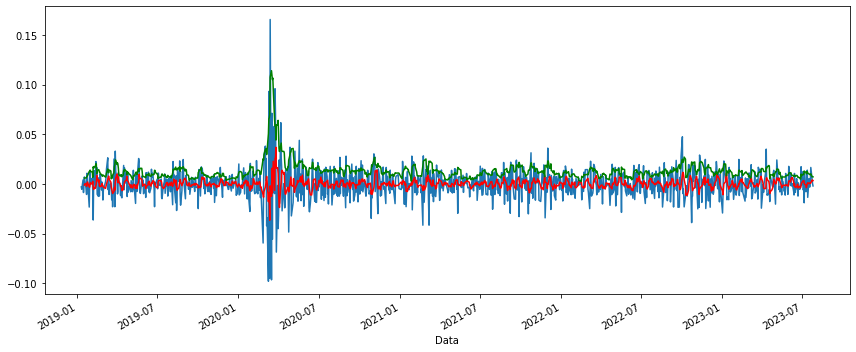

In [19]:
#Diferenciando a série anterior:
serie_diff = serie_s.diff(1)
ma_diff = serie_diff.rolling(6).mean()
std_diff = serie_diff.rolling(6).std()

#Plotando tudo:
f, ax = plt.subplots(figsize = (12, 5))
serie_diff.plot(ax = ax, legend = False)
ma_diff.plot(ax = ax, legend = False, color = "r")
std_diff.plot(ax = ax, legend = False, color = "g")
plt.tight_layout()

In [20]:
#Teste da Serie Diferenciada:
test_adfuller(serie_diff.dropna().values, "Teste p/ Série Diferenciada")

Teste p/ Série Diferenciada
ADF Estatística: -11.465979284411006
p-value: 5.409943493721746e-21
Valores Críticos:
   1%, -3.4362549432361504
Valores Críticos:
   5%, -2.8641473395601595
Valores Críticos:
   10%, -2.568158225793361


Shoow! Olha que bacana o resultado, quando diferenciamos, ela fica ainda mais estacionária e com um valor-p muito pequeno!

##### Auto-Correlações de Séries Temporais

Agora iremos avaliar os aspectos das auto-correlações da série de Abertura, ou seja, como certos períodos da série estão correlacionados com outros períodos dentro da mesma série. No caso do problema das séries temporais, nós temos diferentes tipos de correlações dentro de uma mesma linha de tempo, podendo elas serem diretas ou indiretas. 

In [21]:
#Importando autoc functions:
from statsmodels.tsa.stattools import acf, pacf 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings

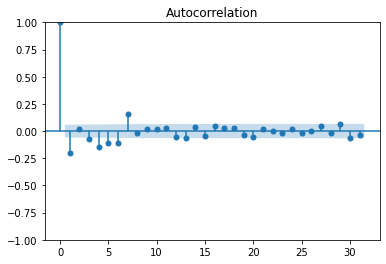

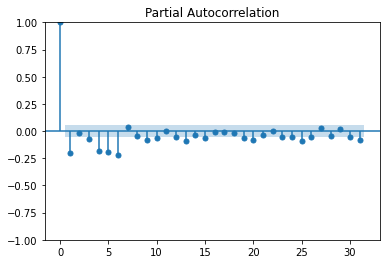

In [22]:
#Graficos de Auto Correlacção e AutoCorrelação Parcial:
warnings.filterwarnings("ignore")
#ACF:
plot_acf(serie_diff.dropna().Último)
#PACF:
plot_pacf(serie_diff.dropna().Último)
plt.show()

#### Conclusões de Exploração

Como vimos nas análises anteriores, temos opções interessantes para etapas de modelagem com intuito de predição de valores futuros. A série é "pouco" volátil quando comparada com ativos individuais, principalmente se retirarmos o fator Pandemia de COVID-19. Além disso, vimos que poucas difereniações são necessárias para atingirmos uma potencial estacionariedade, o que já nos indica possivelmente a usabilidade de um modelo ARIMA para realizarmos as predições. As funções de autocorrelação também indicaram lags próximos de 1 significativos, indicando talvez as ordens dos termos autoregressivos e de médias móveis do modelo.

### Modelando a série final

Importante ressaltar que apesar de termos uma base desde 2019 dos valores de abertura do índice, o fator pandemia do COVID-19 é muito influente no preço do ativo e pode ser considerado um outlier bem significativo. Apesar de sabermos que existe a possibilidade de novas pandemias ocorrerem, pelo fato dessa ter sido uma das mais significativas da era moderna, o mercado não necessariamente esteve preparado para suas consequências. Dessa forma, para termos uma modelagem mais "tranquila" e conseguirmos um resultado interessante para as predições futuras dos valores, iremos trabalhar com a série somente a partir de 2022, o que também ajuda em todos os conceitos vistos anterioremente de estacionariedade e auto-correlações da série.

In [23]:
#Serie Filtrada Pós Pandemia:
df_serie_modelagem = df[["Data", "Último"]].copy() \
    .rename(columns = {"Data": "ds", "Último": "y"}) \
    .query("ds >= '2022-01-01'")
df_serie_modelagem.head()

,ds,y
744,2022-01-03,103.922
745,2022-01-04,103.514
746,2022-01-05,101.006
747,2022-01-06,101.561
748,2022-01-07,102.719


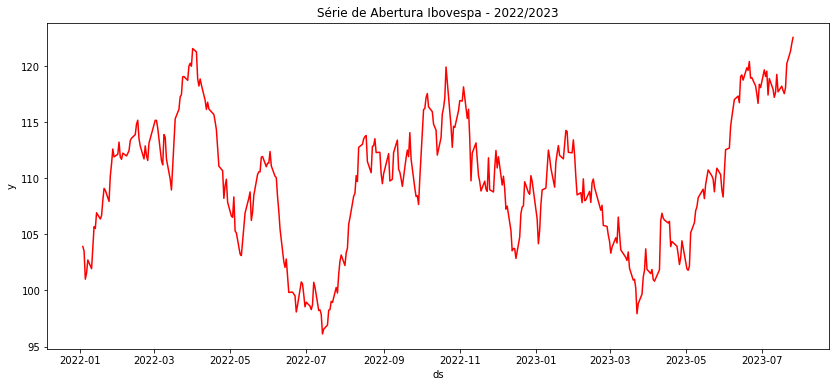

In [24]:
plt.figure(figsize = (14, 6))
sns.lineplot(data = df_serie_modelagem, x = "ds", y = "y", color = "r")
title = plt.title("Série de Abertura Ibovespa - 2022/2023")

Por termos uma série com amplitudes menores quando comparamos a ativos individuais da bolsa brasileira, um modelo mais simples possível utilizando o último valor como base para as predições futuras já traria resultados interessantes acerca do erro de previsão, mas como é a solução mais simples, iremos seguir diretamente para um ajuste mais "rebuscado", o modelo ARIMA. Para o ajuste iremos retomar os passos que fizemos anteriormente de exploração para a série filtrada nessa etapa de modelagem a fim de escolhermos de forma eficiente os parâmetros mais corretos possíveis para um ajuste.

De forma resumida, podemos caracterizar um modelo ARIMA por 3 componentes (termos) principais:

- p: ordem do termo AR (Autoregressivo)
- d: ordem da diferenciação para estacionariedade da série
- q: ordem do termo MA (Média Móvel)

##### Estacionariedade e Escolha dos termos

Como a ideia é utilizar um modelo ARIMA que contem uma parte autoregressiva, é importante garantirmos a condição de estacionariedade da série e verificar a ordem do termo d.

In [25]:
#Teste Série filtrada comum:
test_adfuller(df_serie_modelagem["y"].values, "Teste p/ Série de Modelagem Normal")

Teste p/ Série de Modelagem Normal
ADF Estatística: -2.2027142141464338
p-value: 0.2052618289864654
Valores Críticos:
   1%, -3.4472291365835566
Valores Críticos:
   5%, -2.8689795375849223
Valores Críticos:
   10%, -2.5707330834976987


Assim como já suspeitávamos e também baseado em exporações anteriores da série completa, a série a partir de 2022 também não pode ser considerada estacionária, vide valor-p > 5%. 

Vamos tentar diferenciar uma primeira vez.

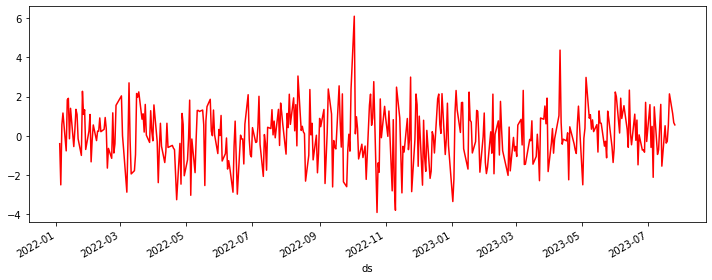

In [26]:
#Diferenciando a série anterior:
df_mod_diff = df_serie_modelagem.set_index("ds").diff(1)

#Plotando tudo:
f, ax = plt.subplots(figsize = (10, 4))
df_mod_diff.plot(ax = ax, legend = False, color = "r")
plt.tight_layout()

In [27]:
#Teste Série filtrada diferenciada:
test_adfuller(df_mod_diff.dropna().values, "Teste p/ Série de Modelagem Diferenciada 1 vez")

Teste p/ Série de Modelagem Diferenciada 1 vez
ADF Estatística: -18.2584440020137
p-value: 2.334122178529758e-30
Valores Críticos:
   1%, -3.4472291365835566
Valores Críticos:
   5%, -2.8689795375849223
Valores Críticos:
   10%, -2.5707330834976987


Agora vemos que atingimos uma suposta estacionariedade após diferenciar a série de modelagem 1 única vez. Vamos também plotar a ACF para verificar se faz sentido seguirmos com apenas 1 diferenciação.

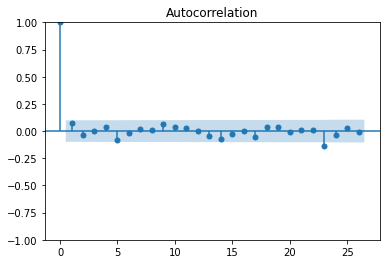

In [28]:
#Plotando ACF p/ Série Diferenciada:
plot_acf(df_mod_diff.dropna());

Aparentemente a escolha de diferenciar 1 vez faz sentido quando verificamos a função de auto correlação da série, com apenas um lag bem a frente levemente fora das bandas de confiança. Podemos só confirmar também usando um pacote que vai nos auxiliar na escolha do termo "d" - pmdarima.

In [29]:
from pmdarima.arima.utils import ndiffs

In [30]:
print("Núm. de Diferenciações Sugeridas p/ Estacionariedade:", ndiffs(df_serie_modelagem["y"], test = "adf"))

Núm. de Diferenciações Sugeridas p/ Estacionariedade: 1


Legal, utilizando o auxilio do pacote acima também chegamos no mesmo resultado quando analisamos os resultados visuais da diferenciação, logo iremos seguir com o termo d = 1.

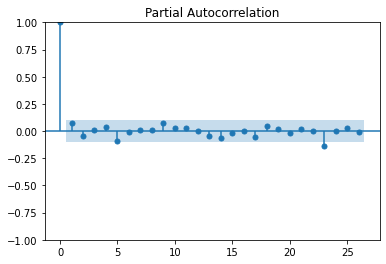

In [31]:
#Plotando PACF p/ Série Diferenciada:
plot_pacf(df_mod_diff.dropna());

Verificando a PACF, vemos que o lag 6 encontra-se levemente fora das bandas de confiança, ou seja, podemos tentar seguir para uma escolha de um termo autoregressivo de p = 6, lembrando que com esse plot verificamos a correlação entre a série de seus próprios lags.

Para o termo da média móvel, podemos seguir também com 6 ou até mesmo 0, ambos podem ser testados e os resultados da modelagem comparados. O mesmo vale para a ordem dos termos autoregressivos, 0 também parece ser adequado.

##### Ajustando um modelo

Ajustando um modelo geral e verificando o resultado.

In [32]:
from statsmodels.tsa.arima.model import ARIMA

In [33]:
#Modelo ARIMA ajustado p/ série completa:
modelo_completo = ARIMA(df_serie_modelagem.set_index("ds").y, order = (6, 1, 6))
resultado_mc = modelo_completo.fit()

In [34]:
resultado_mc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  392
Model:                 ARIMA(6, 1, 6)   Log Likelihood                -675.234
Date:                Mon, 28 Aug 2023   AIC                           1376.468
Time:                        22:20:50   BIC                           1428.061
Sample:                             0   HQIC                          1396.917
                                - 392                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7472      2.418     -0.309      0.757      -5.487       3.992
ar.L2         -0.2018      1.407     -0.143      0.886      -2.960       2.556
ar.L3          0.2780      1.011      0.275      0.783      -1.704       2.260
ar.L4         -0.6861      0.344     -1.994      0.046      -1.360      -0.012
ar.L5         -0.8651      1.434     -0.603      0.546      -3.675       1.945
ar.L6         -0.5078      1.531     -0.332      0.740      -3.508       2.492
ma.L1          0.8283      2.410      0.344      0.731      -3.896       5.553
ma.L2          0.2363      1.479      0.160      0.873      -2.662       3.135
ma.L3         -0.2771      0.961     -0.288      0.773      -2.161       1.607
ma.L4          0.6970      0.280      2.494      0.013       0.149       1.245
ma.L5          0.9171      1.550      0.592      0.554      -2.120       3.954
ma.L6          0.5372      1.552      0.346      0.729      -2.505       3.579
sigma2         1.8182      0.155     11.715      0.000       1.514       2.122
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):                 2.76
Prob(Q):                              0.61   Prob(JB):                         0.25
Heteroskedasticity (H):               0.87   Skew:                             0.02
Prob(H) (two-sided):                  0.42   Kurtosis:                         3.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

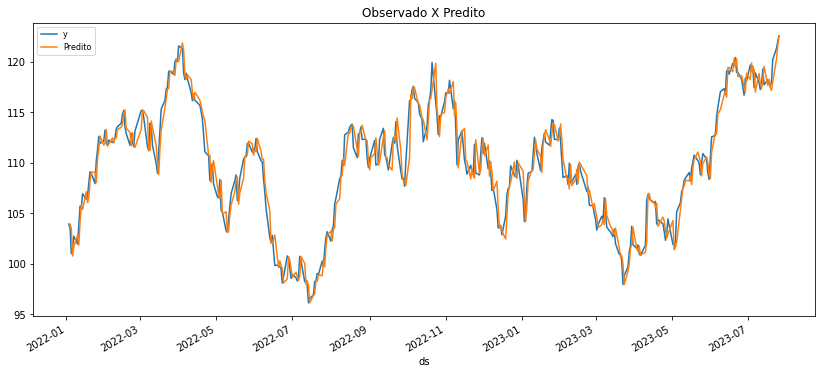

In [35]:
fig, ax = plt.subplots(figsize=(14, 6))    
df_serie_modelagem.set_index("ds").plot(ax=ax,label="Observado")
resultado_mc.predict()[1:].plot(ax=ax,label="Predito")
plt.legend(fontsize=8)
tt = plt.title("Observado X Predito")

Podemos ver que o ajuste ficou extremamente bom, muito próximo dos valores reais da série, entretanto nem todos os coeficientes podem agregar nas predições e a equação tornou-se bem complexa com 6 termos autoregressivos e 6 de médias móveis. Como tínhamos visto anteriormente, é possível realizar um ajuste com termos p e q zerados e ainda sim potencialmente obter bons resultados, vamos verificar.

In [36]:
#Modelo ARIMA ajustado p/ série completa e termos p e q = 0:
modelo_completo_2 = ARIMA(df_serie_modelagem.set_index("ds").y, order = (0, 1, 0))
resultado_mc_2 = modelo_completo_2.fit()

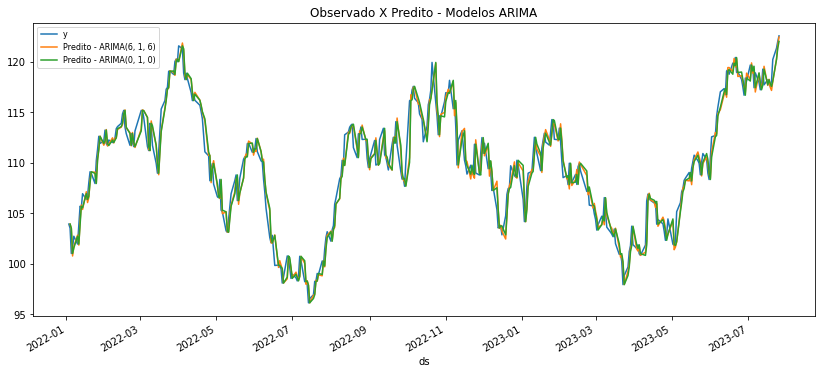

In [37]:
fig, ax = plt.subplots(figsize=(14, 6))    
df_serie_modelagem.set_index("ds").plot(ax=ax,label="Observado")
resultado_mc.predict()[1:].plot(ax=ax,label="Predito - ARIMA(6, 1, 6)")
resultado_mc_2.predict()[1:].plot(ax=ax,label="Predito - ARIMA(0, 1, 0)")
plt.legend(fontsize=8)
tt = plt.title("Observado X Predito - Modelos ARIMA")

Vemos que os resultados são muito similares e o modelo com termos nulos aparenta ser tão eficiente quanto o com mais termos. Vamos usar ambos para realizar predições nos conjuntos de validações e verificar com qual ficamos ao final.

In [38]:
#Conjunto de Treinamento: até -30 dias
df_treino = df_serie_modelagem[df_serie_modelagem["ds"] < '2023-06-01']
df_treino["unique_id"] = "0"
#Conjunto de Validação:
df_validacao = df_serie_modelagem[df_serie_modelagem["ds"] >= '2023-06-01']
df_validacao["unique_id"] = "0"
print(f'Tamanhos dos Conjuntos:\nTotal: {df_serie_modelagem.shape[0]} dias\nTreino: {df_treino.shape[0]} dias\nValidação: {df_validacao.shape[0]} dias')

Tamanhos dos Conjuntos:
Total: 392 dias
Treino: 353 dias
Validação: 39 dias


Um ponto importante é que na bolsa brasileira não temos mercado aberto aos fins de semanas e feriados, dessa forma, precisamos ajustar os feriados desses pontos.

In [39]:
def ajusta_ARIMA(df_treino, p, d, q):
    modelo = ARIMA(df_treino.set_index("ds").y, order = (p, d, q))
    resultado = modelo.fit()
    
    return resultado

In [40]:
#Modelo ARIMA ajustado p/ série de treino:
#ARIMA(6,1,6):
resultado_treino_616 = ajusta_ARIMA(df_treino, 6, 1, 6)

#ARIMA(4,1,4):
resultado_treino_414 = ajusta_ARIMA(df_treino, 4, 1, 4)

#ARIMA(0,1,0):
resultado_treino_010 = ajusta_ARIMA(df_treino, 0, 1, 0)

Vamos avaliar as predições com o WMAPE (Weighted Mean Absolute Percentage Error) que seria uma espécie de erro quadrático médio para podermos avaliar a acruácia de nossas predições futuras.

In [41]:
#Métrica para avaliação:
def wmape(y_true, y_pred):

  y_true = np.array(y_true)
  y_pred = np.array(y_pred)

  weights = np.abs(y_true)

  wmape = np.sum(np.abs(y_true - y_pred) / weights) / np.sum(weights) * 100

  return wmape

In [42]:
#WMAPEs:
wmape_616 = wmape(df_validacao["y"], resultado_treino_616.forecast(df_validacao.shape[0]))
wmape_414 = wmape(df_validacao["y"], resultado_treino_414.forecast(df_validacao.shape[0]))
wmape_010 = wmape(df_validacao["y"], resultado_treino_010.forecast(df_validacao.shape[0]))

In [43]:
#Printando Metricas:
print('''
WMAPE calculados para todos os modelos:

ARIMA(0, 1, 0) = {:.4%}
ARIMA(4, 1, 4) = {:.4%}
ARIMA(6, 1, 6) = {:.4%}
'''.format(wmape_010, wmape_414, wmape_616))


WMAPE calculados para todos os modelos:

ARIMA(0, 1, 0) = 6.9256%
ARIMA(4, 1, 4) = 6.9725%
ARIMA(6, 1, 6) = 7.0021%



Bem, os 3 modelos ficaram muito interessantes, com um erro próximo de 7%, representando um excelente resultado em geral.

In [44]:
df_forecast_geral = pd.DataFrame({
    "ds": df_validacao.ds.values,
    "forecast_010": resultado_treino_010.forecast(df_validacao.shape[0]).values,
    "forecast_414": resultado_treino_414.forecast(df_validacao.shape[0]).values,
    "forecast_616": resultado_treino_616.forecast(df_validacao.shape[0]).values
})
df_forecast_geral.head()

,ds,forecast_010,forecast_414,forecast_616
0,2023-06-01,108.335,108.049913,108.234402
1,2023-06-02,108.335,108.051059,108.142267
2,2023-06-05,108.335,108.441747,108.183932
3,2023-06-06,108.335,108.320809,108.277548
4,2023-06-07,108.335,108.245709,108.314684


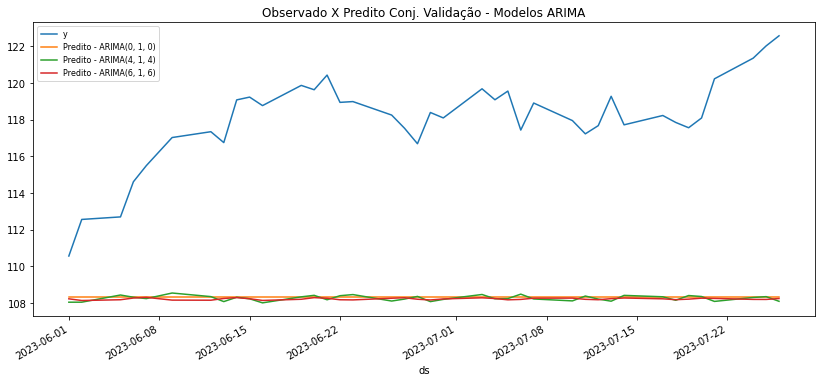

In [45]:
fig, ax = plt.subplots(figsize=(14, 6))    
df_validacao.set_index("ds").plot(ax=ax,label="Observado")
df_forecast_geral.set_index("ds")["forecast_010"].plot(ax=ax,label="Predito - ARIMA(0, 1, 0)")
df_forecast_geral.set_index("ds")["forecast_414"].plot(ax=ax,label="Predito - ARIMA(4, 1, 4)")
df_forecast_geral.set_index("ds")["forecast_616"].plot(ax=ax,label="Predito - ARIMA(6, 1, 6)")
plt.legend(fontsize=8)
tt = plt.title("Observado X Predito Conj. Validação - Modelos ARIMA")

Aqui dá pra ver claramente o que os termos tentam fazer com as predições, em todos os 3 tiveram bons desempenhos e bem parecidos aliás. Claramente o modelo com os termos p e q zerados representa o mais simplificado possível, utilizando somente um valor anterior para as predições futuras. Aqui as diferenças são marginais e não significativas, ou seja, podemos escolher qualquer um dos 3 como um modelo final. 

Vale ressaltar que nem sempre modelos ARIMA's vão ser bons para séries temporais de ativos financeiros, outros modelos com outras técnicas poderiam ser avaliados como os ARMAS e até mesmo LSTM (Deep Learning) - infelizmente para aplicar LSTM dependeriamos de MUITOS dados e não necessariamente seria mais eficiente. Entretanto, como o resultado foi bem satisfatório, iremos seguir com o modelo mais simples pois performou muito bem e é o menos complexo em questão de termos. Além disso, por se tratar de uma série menos volátil, se formos retreinando o modelo com os dados novos podemos continuar tendo bons desempenhos.

Outro fator interessante é que ativos financeiros não necessariamente são sazonais, uma vez que são altamente influenciáveis por eventos macroeconomicos e até mesmo políticos ao redor do mundo. Por exemplo, como mostrado anteriomente ativos financeiros na bolsa brasileira apresentam ciclos em torno dos aumentos e reduções da taxa básica de juros brasileira, SELIC. Logo, por mais que tenhamos tido um ótimo resultado nas predições futuras de alguns dias, isso não garante um retorno médio positivo, visto a voltatividade desse tipo de dado. Vale lembrar, se prever ativos financeiros fosse simples todos estariamos ricos! rsrs.